(example_remove_sharp_peaks)=

# Removing sharp peaks

This example shows how the peak removal function can be used to remove sharp, short peaks from a signal, e.g. from neutron/gamma noise in an APDCAM signal.[^download]

[^download]: This notebook can be downloaded as **{download}`remove_sharp_peaks.ipynb`**

Note that the implemented peak removal algorithm assumes that the duration (~ 5x time constant) of the peaks is a few dozen samples, their total duration is at most a few percent of the signal duration and their height is always positive and such that the resulting signal derivative is significantly larger than that of anything important in the underlying signal.

In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

import flap
import flap.testdata

Default location of configuration file is working directory.
INIT flap storage


## Generating the test data

In [2]:
flap.testdata.register()

### Pure signals

In [3]:
d = flap.get_data('TESTDATA',
                  name='TEST-[1-3]-1',
                  options={'Scaling':'Volt'},
                  coordinates={'Time':[0,0.005]},
                 )

In [4]:
dt = d.get_coordinate_object('Time').step[0]

In [5]:
flap.list_data_objects(d)


-----------------------------
<1>(data_source:"TESTDATA" exp_id:"") data_title:"Test data" shape:[3,5001][no error]
  Data name:"Signal", unit:"Volt"
  Coords:
Time [Second](Dims:1) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  1.000E-06
Sample [a.u.](Dims:1) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  1.000E+00
Signal name [a.u.](Dims:0), Shape:[3]) [<R. symm.>] Val:TEST-1-1, TEST-2-1, TEST-3-1
Column [a.u.](Dims:0), Shape:[3]) [<R. symm.>] Val:1, 2, 3
Row [a.u.](Dims:0), Shape:[3]) [<R. symm.>] Val:1, 1, 1


'\n-----------------------------\n<1>(data_source:"TESTDATA" exp_id:"") data_title:"Test data" shape:[3,5001][no error]\n  Data name:"Signal", unit:"Volt"\n  Coords:\nTime [Second](Dims:1) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  1.000E-06\nSample [a.u.](Dims:1) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  1.000E+00\nSignal name [a.u.](Dims:0), Shape:[3]) [<R. symm.>] Val:TEST-1-1, TEST-2-1, TEST-3-1\nColumn [a.u.](Dims:0), Shape:[3]) [<R. symm.>] Val:1, 2, 3\nRow [a.u.](Dims:0), Shape:[3]) [<R. symm.>] Val:1, 1, 1'

### Add noise

Adding some white noise and the peaks that will be filtered

In [6]:
from copy import deepcopy

In [7]:
np.random.seed(12345) # fix the random seed for this example

In [8]:
# Create noisy test dataset
d_noisy = deepcopy(d)

In [9]:
# Add some white noise
white_noise = np.random.random(d.data.shape)*0.025
d_noisy.data += white_noise

In this example, peaks are modelled as an impulse response of a first-order system with randomized amplitude, with additional clipping to model the saturation of a sensor. Their occurrence is also randomized in this example.

In [10]:
def exponential_impulse_response(t, t0, tau, A):
    # t: time array to use for sampling
    # t0: time of impulse (Dirac delta) input
    # tau: time constant
    # A: amplitude
    out = np.zeros_like(t, dtype='float')

    active = (t >= t0)
    out[active] = A * np.exp(-1/tau * (t-t0)[active])

    return out

In [11]:
peaks = np.zeros_like(d.data)
times = d.coordinate('Time')[0]

# Number of peaks to generate
N_peaks = 10

# Time constant of peaks
tau = 1/5e5

for i in range(len(times)):
    for n in range(N_peaks):
        A = np.random.random()*2.0+0.5
        t0 = np.random.random()*times[i].max()
        peaks[i, :] += np.clip(exponential_impulse_response(times[i], t0, tau, A), a_min=-np.inf, a_max=A/2)

# Add the sharp peaks
d_noisy.data += peaks

The signal to be filtered:

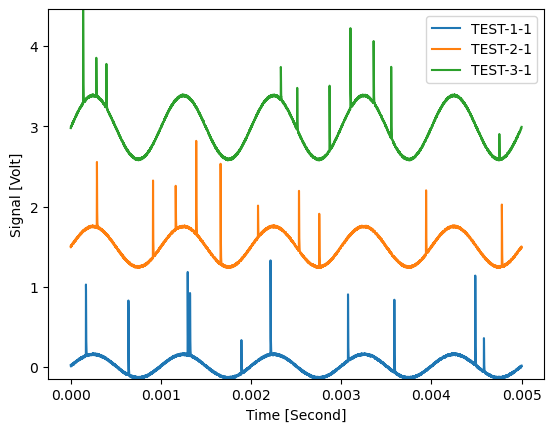

In [12]:
plt.figure()
d_noisy.plot(axes=['Time'], plot_type='multi xy')
plt.show()

Zoom in on a single peak:

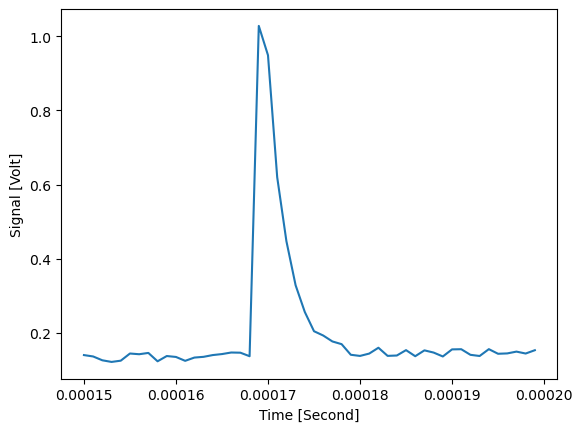

In [13]:
plt.figure()
d_noisy.slice_data({'Signal name' : 'TEST-1-1', 'Time' : flap.Intervals(0.00015, 0.00020)}).plot()
plt.show()

## Removing the peaks

With infinitely fast sampling, the peak width would be about 5 time constants:

In [14]:
int(5*tau / dt)

10

However, the sampling time and the time constant are close, so `max_width_samples` has to be increased a bit.

The value of `diff_limit` (measured in units of data unit / time) depends on both the peaks and the underlying value of the noise and the signal as well.

In a practical situation, these two parameters should be calibrated from measurements.

Options for peak removal follow the standard FLAP option style (`flap_defaults.cfg` can also be used):

In [15]:
peak_removal_options = {
    'diff_limit' : 25000,
    'max_width_samples' : 12,
    'return_num_detected_peaks' : True,
}

Remove the peaks with the given denoising parameters:

In [16]:
d_removed = d_noisy.remove_sharp_peaks(options=peak_removal_options)

As `return_num_detected_peaks` is set to True, we can check how many peaks were removed:

In [17]:
for key, value in d_removed.info.items():
    print(f'{key}: {value}')

num_peak_samples_detected: [94 88 89]
num_peaks_detected: [10 10 10]
num_peak_samples_removed: [94 88 89]
num_peaks_removed: [10 10 10]


10 peaks were removed from every signal. (The samples inbetween were interpolated.)

Check the results:

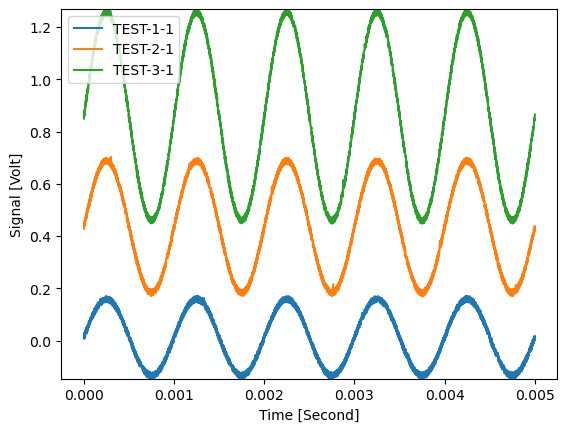

In [18]:
plt.figure()
d_removed.plot(axes=['Time'], plot_type='multi xy')
plt.show()

## Advanced functionality

Now, we do not want to remove anything, but would like to analyze the detected peaks.

In [19]:
peak_removal_options2 = {
    'diff_limit' : 25000,
    'max_width_samples' : 12,
    'remove_peaks' : False,
    'return_num_detected_peaks' : True,
    'return_loc_detected_samples' : True,
    'return_peak_shapes' : True,
}

In [20]:
d_removed_2, peak_widths_array, peak_amplitudes_array = d_noisy.remove_sharp_peaks(options=peak_removal_options2)

### Peak locations

As `return_loc_detected_samples` is True, an additional coordinate named 'Peak detected' is added to the returned data object, which contains whether the associated sample has been detected to be a part of a sample:

In [21]:
flap.list_data_objects(d_removed_2)


-----------------------------
<1>(data_source:"TESTDATA" exp_id:"") data_title:"Test data" shape:[3,5001][no error]
  Data name:"Signal", unit:"Volt"
  Coords:
Time [Second](Dims:1) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  1.000E-06
Sample [a.u.](Dims:1) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  1.000E+00
Signal name [a.u.](Dims:0), Shape:[3]) [<R. symm.>] Val:TEST-1-1, TEST-2-1, TEST-3-1
Column [a.u.](Dims:0), Shape:[3]) [<R. symm.>] Val:1, 2, 3
Row [a.u.](Dims:0), Shape:[3]) [<R. symm.>] Val:1, 1, 1
Peak detected [Bool](Dims:0,1), Shape:[3,5001]) [<R. symm.>] Val. range:  0.000E+00 -  1.000E+00


'\n-----------------------------\n<1>(data_source:"TESTDATA" exp_id:"") data_title:"Test data" shape:[3,5001][no error]\n  Data name:"Signal", unit:"Volt"\n  Coords:\nTime [Second](Dims:1) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  1.000E-06\nSample [a.u.](Dims:1) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  1.000E+00\nSignal name [a.u.](Dims:0), Shape:[3]) [<R. symm.>] Val:TEST-1-1, TEST-2-1, TEST-3-1\nColumn [a.u.](Dims:0), Shape:[3]) [<R. symm.>] Val:1, 2, 3\nRow [a.u.](Dims:0), Shape:[3]) [<R. symm.>] Val:1, 1, 1\nPeak detected [Bool](Dims:0,1), Shape:[3,5001]) [<R. symm.>] Val. range:  0.000E+00 -  1.000E+00'

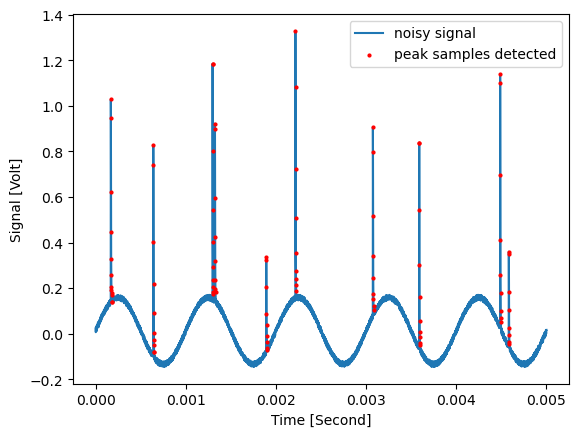

In [22]:
peak_detected_0 = np.asarray(d_removed_2.coordinate('Peak detected')[0][0], dtype='bool')

plt.figure()

plt.plot(d_removed_2.coordinate('Time')[0][0], d_removed_2.data[0], label='noisy signal')
plt.scatter(d_removed_2.coordinate('Time')[0][0][peak_detected_0], d_removed_2.data[0][peak_detected_0], s=4, c='r', zorder=100, label='peak samples detected')

plt.legend()
plt.xlabel('Time [Second]')
plt.ylabel('Signal [Volt]')

plt.show()

### Peak shapes

The two arrays additional arrays returned due to setting `return_peak_shapes` have a shape similar to the data in the original data object:

In [23]:
print(peak_amplitudes_array.shape)

(3, 1)


In [24]:
print(peak_widths_array.shape)

(3, 1)


They contain separate data objects for each signal, with the time coordinates being the center times of the detected peaks:

In [25]:
for i in range(len(peak_amplitudes_array)):
    flap.list_data_objects(peak_amplitudes_array[i, 0])
    print()


-----------------------------
<1>(data_source:"" exp_id:"") data_title:"" shape:[10][no error]
  Data name:"Signal", unit:"Volt"
  Coords:
Time [Second](Dims:0), Shape:[10]) [<R. symm.>] Val: 1.745E-04,  6.445E-04,  1.301E-03,  1.326E-03,  1.896E-03,  2.220E-03,  3.079E-03,  3.593E-03,  4.490E-03,  4.586E-03


-----------------------------
<1>(data_source:"" exp_id:"") data_title:"" shape:[10][no error]
  Data name:"Signal", unit:"Volt"
  Coords:
Time [Second](Dims:0), Shape:[10]) [<R. symm.>] Val: 2.935E-04,  9.165E-04,  1.167E-03,  1.396E-03,  1.667E-03,  2.080E-03,  2.535E-03,  2.759E-03,  3.943E-03,  4.784E-03


-----------------------------
<1>(data_source:"" exp_id:"") data_title:"" shape:[10][no error]
  Data name:"Signal", unit:"Volt"
  Coords:
Time [Second](Dims:0), Shape:[10]) [<R. symm.>] Val: 1.420E-04,  2.875E-04,  3.995E-04,  2.334E-03,  2.515E-03,  2.873E-03,  3.106E-03,  3.363E-03,  3.559E-03,  4.756E-03



In [26]:
for i in range(len(peak_amplitudes_array)):
    flap.list_data_objects(peak_widths_array[i, 0])
    print()


-----------------------------
<1>(data_source:"" exp_id:"") data_title:"" shape:[10][no error]
  Data name:"Samples", unit:"[n.a.]"
  Coords:
Time [Second](Dims:0), Shape:[10]) [<R. symm.>] Val: 1.745E-04,  6.445E-04,  1.301E-03,  1.326E-03,  1.896E-03,  2.220E-03,  3.079E-03,  3.593E-03,  4.490E-03,  4.586E-03


-----------------------------
<1>(data_source:"" exp_id:"") data_title:"" shape:[10][no error]
  Data name:"Samples", unit:"[n.a.]"
  Coords:
Time [Second](Dims:0), Shape:[10]) [<R. symm.>] Val: 2.935E-04,  9.165E-04,  1.167E-03,  1.396E-03,  1.667E-03,  2.080E-03,  2.535E-03,  2.759E-03,  3.943E-03,  4.784E-03


-----------------------------
<1>(data_source:"" exp_id:"") data_title:"" shape:[10][no error]
  Data name:"Samples", unit:"[n.a.]"
  Coords:
Time [Second](Dims:0), Shape:[10]) [<R. symm.>] Val: 1.420E-04,  2.875E-04,  3.995E-04,  2.334E-03,  2.515E-03,  2.873E-03,  3.106E-03,  3.363E-03,  3.559E-03,  4.756E-03



The amplitude array contains the height of the peaks relative to the underlying signal:

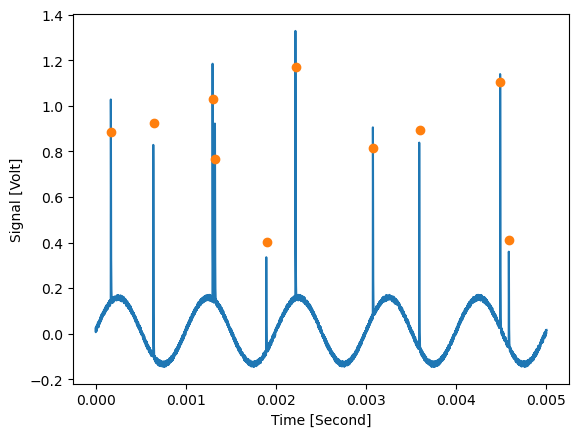

In [27]:
plt.figure()

d_removed_2.slice_data({'Signal name' : 'TEST-1-1'}).plot()
peak_amplitudes_array[0, 0].plot(plot_type='scatter')

plt.show()

These arrays can be used to generate various statistics on the peaks:

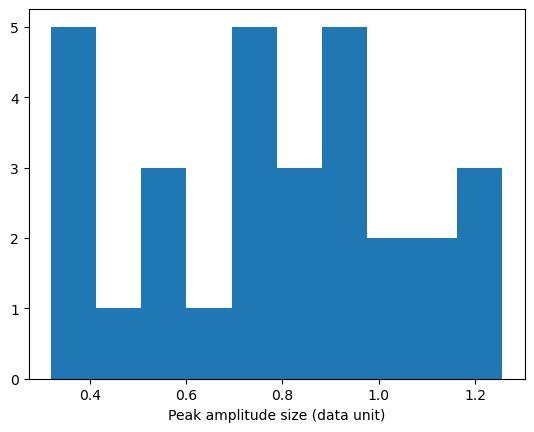

In [28]:
peak_amplitudes = np.array([])

for d_i in peak_amplitudes_array.flat:
    peak_amplitudes = np.concatenate((peak_amplitudes, d_i.data))

plt.figure()
plt.hist(peak_amplitudes)
plt.xlabel('Peak amplitude size (data unit)')
plt.show()

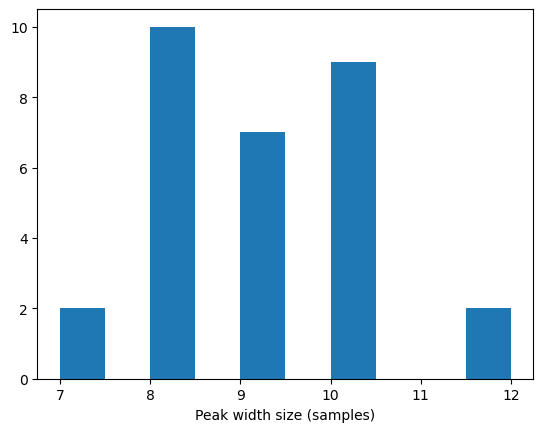

In [29]:
peak_widths = np.array([])

for d_i in peak_widths_array.flat:
    peak_widths = np.concatenate((peak_widths, d_i.data))

plt.figure()
plt.hist(peak_widths)
plt.xlabel('Peak width size (samples)')
plt.show()

Analyze the effect of `diff_limit` on the number of samples removed:

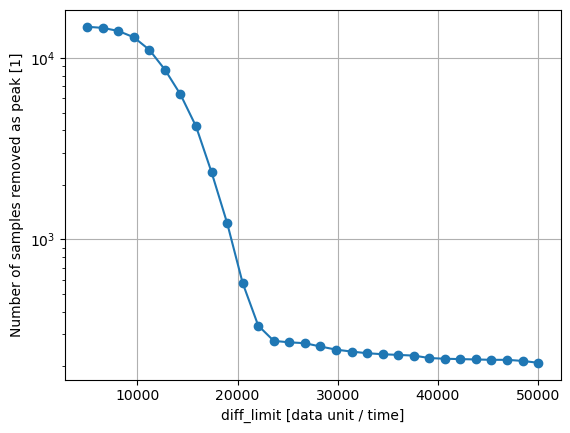

In [30]:
diff_limits = np.linspace(5000, 50000, 30)

removed_peak_samples_number = []

for diff_limit_i in diff_limits:
    peak_removal_options_i = {
        'diff_limit' : diff_limit_i,
        'max_width_samples' : 12,
        'remove_peaks' : False,
        'return_num_detected_peaks' : True,
    }
    
    d_removed_i = d_noisy.remove_sharp_peaks(options=peak_removal_options_i)

    removed_peak_samples_number.append(np.sum(d_removed_i.info['num_peak_samples_detected']))

plt.figure()
plt.plot(diff_limits, removed_peak_samples_number, marker='o')
plt.yscale('log')

plt.xlabel('diff_limit [data unit / time]')
plt.ylabel('Number of samples removed as peak [1]')

plt.grid()

plt.show()

## Effect of sampling and phase shift on detected peak duration

If a an impulse occurs with a phase shift relative to the sampling time instants, the sampled response will have a different observed duration depending on the (sampling time) / (time constant) ratio, as well as the phase shift. The following two graphs illustrate this effect.

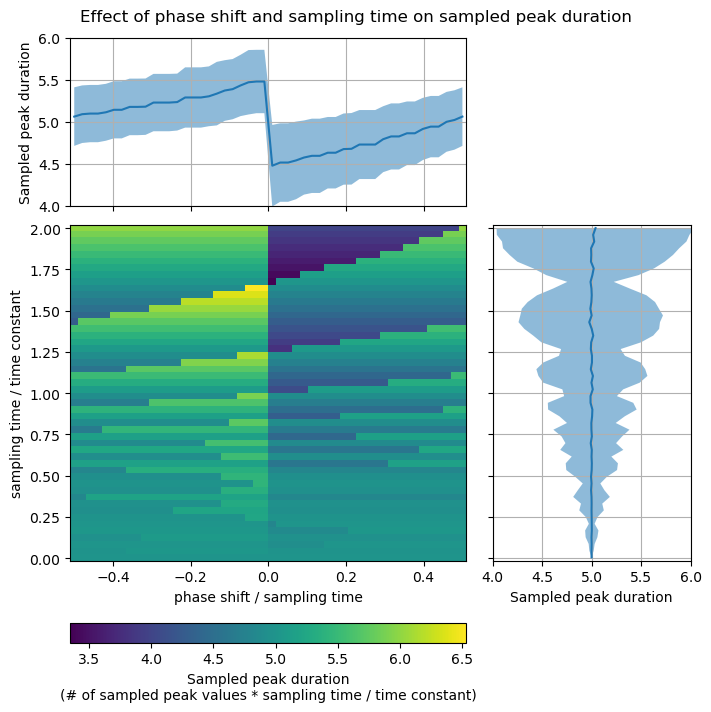

In [31]:
tau = 1

dt_n = np.linspace(0.005*tau, 2*tau, 50)
phase_shift_over_dt_n = np.linspace(-0.5, 0.5, 50)
A_test = 1

A_limit = A_test * np.exp(-5)  # 5 time constants exponential decay

num_samples = np.full((len(phase_shift_over_dt_n), len(dt_n)), np.nan)

for i in range(len(phase_shift_over_dt_n)):
    for j in range(len(dt_n)):
        dt = dt_n[j]
        times = np.arange(0, 10*tau, step=dt)
        num_samples[i, j] = np.sum(exponential_impulse_response(times, dt + phase_shift_over_dt_n[i] * dt, tau, A_test) >= A_limit) * dt / tau

# remove upper corner plot
fig = plt.figure(figsize=(7,7), constrained_layout=True)

axcorner = plt.subplot2grid((3, 3), (0, 2))
axcorner.axis('off')

axmain = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)

psodtn_step = phase_shift_over_dt_n[1] - phase_shift_over_dt_n[0]
dtn_step = dt_n[1] - dt_n[0]

m = axmain.imshow(
    num_samples.T,
    extent=(
        np.min(phase_shift_over_dt_n) - psodtn_step / 2,
        np.max(phase_shift_over_dt_n) + psodtn_step / 2,
        np.min(dt_n) - dtn_step / 2,
        np.max(dt_n) + dtn_step / 2,
    ),
    aspect='auto',
    origin='lower',
    interpolation='none',
)

axmain.set_xlabel('phase shift / sampling time')
axmain.set_ylabel('sampling time / time constant')

fig.colorbar(
    m,
    ax=axmain,
    label='Sampled peak duration\n(# of sampled peak values * sampling time / time constant)',
    orientation='horizontal',
)

vertMean = np.mean(num_samples, axis=1)
vertStd = np.std(num_samples, axis=1)
axtop = plt.subplot2grid((3, 3), (0, 0), colspan=2, sharex=axmain)
axtop.fill_between(phase_shift_over_dt_n, vertMean - vertStd, vertMean + vertStd, alpha=0.5)
axtop.plot(phase_shift_over_dt_n, vertMean)
    
axtop.label_outer()
axtop.set_ylim(4, 6)
axtop.set_yticks(np.arange(4, 6+0.1, 0.5))
axtop.set_ylabel('Sampled peak duration')
axtop.grid()

horzMean = np.mean(num_samples, axis=0)
horzStd = np.std(num_samples, axis=0)
axright = plt.subplot2grid((3, 3), (1, 2), rowspan=2, sharey=axmain)
axright.fill_betweenx(dt_n, horzMean - horzStd, horzMean + horzStd, alpha=0.5)
axright.plot(horzMean, dt_n)

axright.label_outer()
axright.set_xlim(axtop.get_ylim())
axright.set_xticks(axtop.get_yticks())
axright.set_xlabel('Sampled peak duration')
axright.grid()

plt.suptitle('Effect of phase shift and sampling time on sampled peak duration')
plt.show()

An illustrative case corresponding to the top right region of the above map:

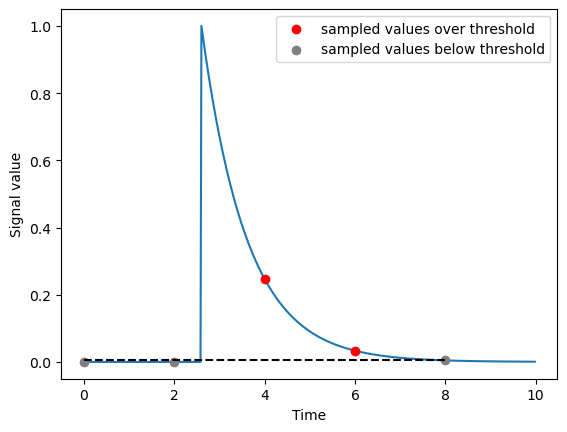

In [32]:
dt = 2
tau = 1

phase_shift_over_dt = +0.3

times = np.arange(0, 10*tau, step=dt)
pulse_sampled = exponential_impulse_response(times, dt + phase_shift_over_dt * dt, tau, 1)
detected = pulse_sampled >= np.exp(-5)

times_ref = np.arange(0, 10*tau, step=dt/100)
pulse_ref = exponential_impulse_response(times_ref, dt + phase_shift_over_dt * dt, tau, 1)

plt.figure()

plt.plot(
    times_ref,
    pulse_ref,
    zorder=-2,
)

plt.scatter(
    times[detected],
    pulse_sampled[detected],
    c='red',
    label='sampled values over threshold',
)

plt.scatter(
    times[~detected],
    pulse_sampled[~detected],
    c='gray',
    label='sampled values below threshold',
)

plt.hlines(np.exp(-5), times.min(), times.max(), ls='--', color='k')

plt.xlabel('Time')
plt.ylabel('Signal value')

plt.legend()

plt.show()